<h1>Training</h1>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<p>There are many ways to optimize a neural network. Although Gradient Descent performs well, it still has it's limitations in the way that it could get stuck in a local minimum. Another way we can make sure our gradients and cost function are correct is to implement one of the optimization algorithms contained in the scipy package called the BFGS algorithm. This algorithm takes in a function, with the input and output data, and returns a cost and the gradients. Stephen Welch includes a wrapper function in the trainer method to implement this behavior in our neural network as seen below.</p>

In [2]:
import scipy as sp

In [3]:
import numpy as np

In [4]:
from scipy import optimize

In [5]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [6]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 

In [7]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = sp.optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

<p>After our network is trained, the trainer method replaces our random values for W with the trained values.</p>

In [8]:
NN = Neural_Network()

In [9]:
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

In [10]:
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

In [11]:
T = trainer(NN)

In [12]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 66
         Gradient evaluations: 66


<p>If we plot the cost against the number of iterations it takes to train the network, we can see the function decrease monotonically each time it trains the network with new gradients and costs. Additionally, we can see from the training output that it only took us 37 evaluations to minimize the cost function.</p>

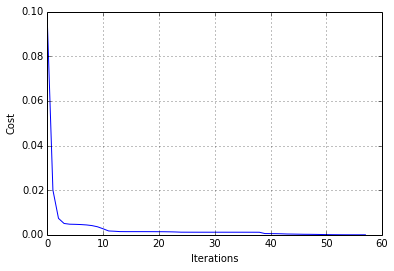

In [13]:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

<p>As another way to error check our code, we can evaluate our gradients at our solution and expect to see very small values.</p>

In [14]:
NN.costFunctionPrime(X,y)

(array([[  3.55213002e-07,   3.33016142e-07,  -2.12274915e-07],
        [  2.57061523e-07,   3.80138729e-07,  -6.36478690e-07]]),
 array([[  1.41137957e-06],
        [  1.06096755e-06],
        [  9.59871847e-07]]))

<p>At this point we have trained our network to predict an accurate score, which we can test by running our new trained data through the feed forward method.</p>

In [15]:
NN.forward(X)

array([[ 0.75000229],
       [ 0.82002058],
       [ 0.9299756 ]])

In [16]:
y

array([[ 0.75],
       [ 0.82],
       [ 0.93]])

<p>As you can see, the values are very close to one another, validating our neural network! Now let's examine our input space for many values of sleeping and studying.</p>

In [17]:
#Test network for various combinations of sleep/study:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [18]:
allOutputs = NN.forward(allInputs)

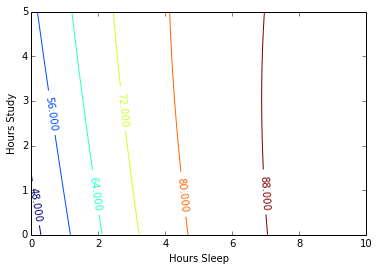

In [19]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

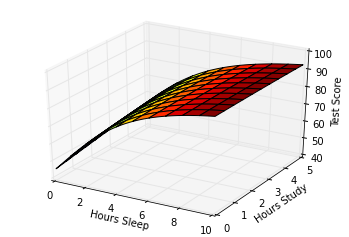

In [20]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

<br>

<p>Our results look quite reasonable, and it seems like sleep actually had a greater impact on test score than hours studying which is interesting. At this point it may seem like we have successfully trained our network, but we made one of the most common mistakes in Neural Networks, we overfit our data.</p>

<h1>Overfitting, Testing, and Regularization</h1>

<p>Let's modify our data a bit to make our overfitting mistake more apparent.</p>

In [21]:
NN = Neural_Network()

In [22]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

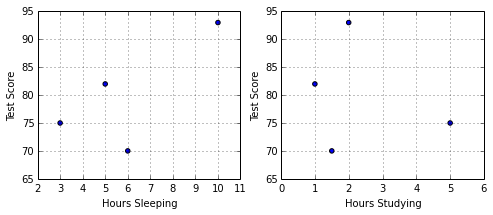

In [23]:
#Plot projections of our new data:
fig = figure(0,(8,3))

subplot(1,2,1)
scatter(X[:,0], y)
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(1,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')

In [24]:
#Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

In [25]:
#Train network with new data:
T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 129
         Gradient evaluations: 129


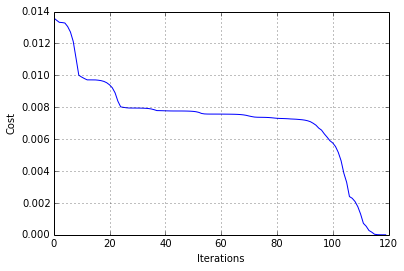

In [26]:
#Plot cost during training:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [27]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [28]:
allOutputs = NN.forward(allInputs)

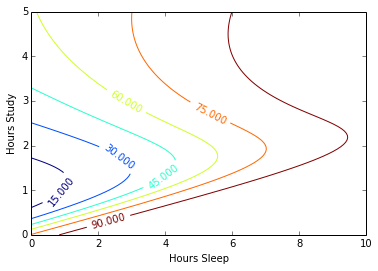

In [29]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

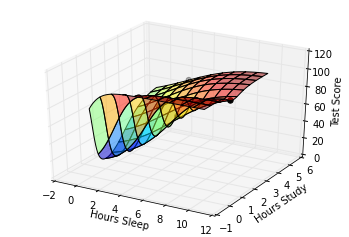

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#Scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

<p>If we reexamine our solution space, we see how our model is overfitting the data. Our data is too closely fit to our input data, and this makes our network no longer reflective of the real world. One way to fix this problem is to have more examples for our network. For each weight, there is a general rule of thumb that you should have ten test cases. In our case that would mean we would need 90 sets of data for sleeping, studying, and test score. Since we do not have that much data we will have to use another strategy to correctly fit our network.</p>

<p>Let's split our data into training and testing data to find the exact point where overfitting begins.</p>

In [31]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [32]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [33]:
#Train network with new data:
NN = Neural_Network()

T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 192
         Function evaluations: 214
         Gradient evaluations: 214


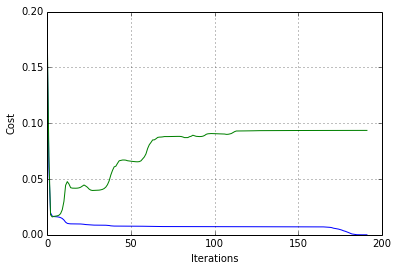

In [34]:
#Plot cost during training:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

<p>We can see that our model is overfitting our data around iteration 20-40. How can we use this data to penalize our model for overfitting? One solution is to introduce a "Regularization" parameter, lambda to our function. This value of lambda will allow us to tune our cost function. As lambda gets too big, bigger penalties will be imposed on our model.</p>

In [35]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(sum(self.W1**2)+sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [36]:
NN = Neural_Network(Lambda=0.001)

In [37]:
#Make sure our gradients our correct after making changes:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)

In [38]:
#Should be less than 1e-8:
norm(grad-numgrad)/norm(grad+numgrad)

2.8650608466835125e-10

In [39]:
T = trainer(NN)

In [40]:
T.train(X,y,testX,testY)

Optimization terminated successfully.
         Current function value: 0.004364
         Iterations: 40
         Function evaluations: 43
         Gradient evaluations: 43


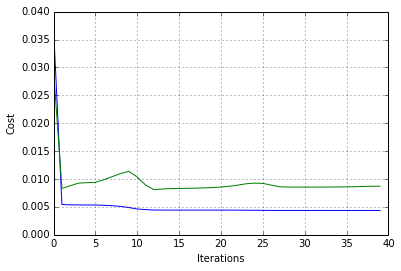

In [41]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

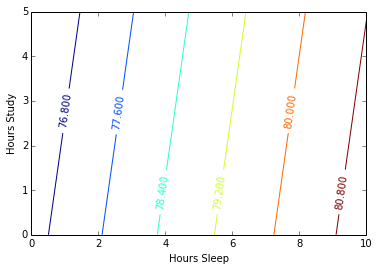

In [42]:
allOutputs = NN.forward(allInputs)

#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

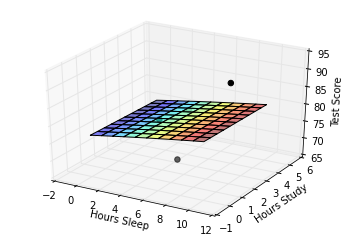

In [43]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

<p>With the regularization parameter added, we can see that our model is not interested in exactly fitting our data anymore, our training and testing errors are closer, and we have reduced overfitting on our model. We can further reduce overfitting by increasing and tuning lambda. 
<br>
<p>That is the end of my exploration into how to build Artificial Neural Networks. We have successfully built a neural network that, given some training and testing examples, is able to predict an output and learn. Next week we will start Image Recognition in Google's Machine Learning Abstraction Library, TensorFlow.</p>